## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-spaceNet-wavelet-green' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/wavelet/approx1e5/green'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [01:08<00:00, 1449.35it/s]


Layer 3


100%|██████████| 100000/100000 [00:44<00:00, 2261.91it/s]


Layer 4


100%|██████████| 100000/100000 [00:44<00:00, 2227.66it/s]


Layer 5


100%|██████████| 100000/100000 [00:43<00:00, 2280.53it/s]


Layer 6


100%|██████████| 100000/100000 [00:44<00:00, 2244.91it/s]


Layer 7


100%|██████████| 100000/100000 [00:44<00:00, 2262.41it/s]


Layer 8


100%|██████████| 100000/100000 [00:43<00:00, 2275.12it/s]


Layer 9


100%|██████████| 100000/100000 [00:43<00:00, 2287.70it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,20586.120000,19258.777000,21997.203000,4.579008,3.067372,6.877853,27208.0
3,5586.042500,5083.030300,6169.862300,12.162527,6.823176,25.538519,108832.0
4,1803.625200,1653.475500,1972.172700,9.509400,6.386293,18.198275,333298.0
5,518.531700,474.718600,568.606450,10.222363,6.526305,26.454138,1149538.0
6,123.448410,112.812614,135.501390,10.630472,6.988778,22.231544,4251250.0
7,26.474886,23.729076,30.007523,18.564669,9.779378,60.509160,17005000.0
8,5.566022,4.824710,6.910763,45.434100,13.918406,216.776810,68020000.0
9,1.021803,0.856540,1.428081,105.147964,15.814442,464.557600,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,20586.120000,19743.030059,21437.694551,4.579008,3.532621,5.910701,27208.0,0.21,0.0,0.021025,0.008227
3,5586.042500,5417.664475,5765.354583,12.162527,9.413560,15.798087,108832.0,0.09,-1.3,0.133080,0.004115
4,1803.625200,1755.617276,1853.797237,9.509400,8.019747,11.794445,333298.0,0.13,-1.2,0.077800,0.002352
5,518.531700,503.764754,533.565198,10.222363,8.006937,14.123384,1149538.0,0.17,-1.1,0.043123,0.001267
6,123.448410,119.933077,127.200839,10.630472,8.700920,13.620480,4251250.0,0.22,-1.0,0.027734,0.000659
7,26.474886,25.543394,27.486594,18.564667,12.586223,29.577342,17005000.0,0.28,-1.0,0.015915,0.000329
8,5.566022,5.285992,5.909213,45.434103,18.767398,96.195189,68020000.0,0.42,-1.0,0.012391,0.000165
9,1.021803,0.950948,1.125916,105.147970,24.340990,239.327557,272080000.0,1.30,-1.0,0.025334,0.000082


### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,20586.120000,19743.030059,21437.694551,4.579008,3.532621,5.910701,27208.0,0.21,0.0,0.021025,0.008227,0.021025,0.21
3,5586.042500,5417.664475,5765.354583,12.162527,9.413560,15.798087,108832.0,0.09,-1.3,0.133080,0.004115,0.133090,0.28
4,1803.625200,1755.617276,1853.797237,9.509400,8.019747,11.794445,333298.0,0.13,-1.2,0.077800,0.002352,0.089807,0.29
5,518.531700,503.764754,533.565198,10.222363,8.006937,14.123384,1149538.0,0.17,-1.1,0.043123,0.001267,0.075252,0.33
6,123.448410,119.933077,127.200839,10.630472,8.700920,13.620480,4251250.0,0.22,-1.0,0.027734,0.000659,0.057525,0.40
7,26.474886,25.543394,27.486594,18.564667,12.586223,29.577342,17005000.0,0.28,-1.0,0.015915,0.000329,0.063554,0.59
8,5.566022,5.285992,5.909213,45.434103,18.767398,96.195189,68020000.0,0.42,-1.0,0.012391,0.000165,0.065062,1.44
9,1.021803,0.950948,1.125916,105.147970,24.340990,239.327557,272080000.0,1.30,-1.0,0.025334,0.000082,0.118568,6.00


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,20586.120000,19743.030059,21437.694551,4.579008,3.532621,5.910701,27208.0,0.21,0.0,0.021025,0.008227,0.021025,0.21,0.204,-0.10,0.019212,0.204,-0.10,0.019212,5101
3,5586.042500,5417.664475,5765.354583,12.162527,9.413560,15.798087,108832.0,0.09,-1.3,0.133080,0.004115,0.133090,0.28,0.087,-1.37,0.133080,0.087,-1.37,0.133080,106
4,1803.625200,1755.617276,1853.797237,9.509400,8.019747,11.794445,333298.0,0.13,-1.2,0.077800,0.002352,0.089807,0.29,0.120,-1.24,0.077800,0.120,-1.24,0.077800,306
5,518.531700,503.764754,533.565198,10.222363,8.006937,14.123384,1149538.0,0.17,-1.1,0.043123,0.001267,0.075252,0.33,0.161,-1.14,0.043118,0.161,-1.14,0.043118,945
6,123.448410,119.933077,127.200839,10.630472,8.700920,13.620480,4251250.0,0.22,-1.0,0.027734,0.000659,0.057525,0.40,0.224,-0.97,0.020647,0.224,-0.97,0.020647,4151
7,26.474886,25.543394,27.486594,18.564667,12.586223,29.577342,17005000.0,0.28,-1.0,0.015915,0.000329,0.063554,0.59,0.271,-1.02,0.013502,0.271,-1.02,0.013502,10507
8,5.566022,5.285992,5.909213,45.434103,18.767398,96.195189,68020000.0,0.42,-1.0,0.012391,0.000165,0.065062,1.44,0.420,-1.00,0.012391,0.420,-1.00,0.012391,12454
9,1.021803,0.950948,1.125916,105.147970,24.340990,239.327557,272080000.0,1.30,-1.0,0.025334,0.000082,0.118568,6.00,1.290,-1.03,0.025333,1.290,-1.03,0.025333,2952


## Comparing Empirical and Computed CDF/PDF

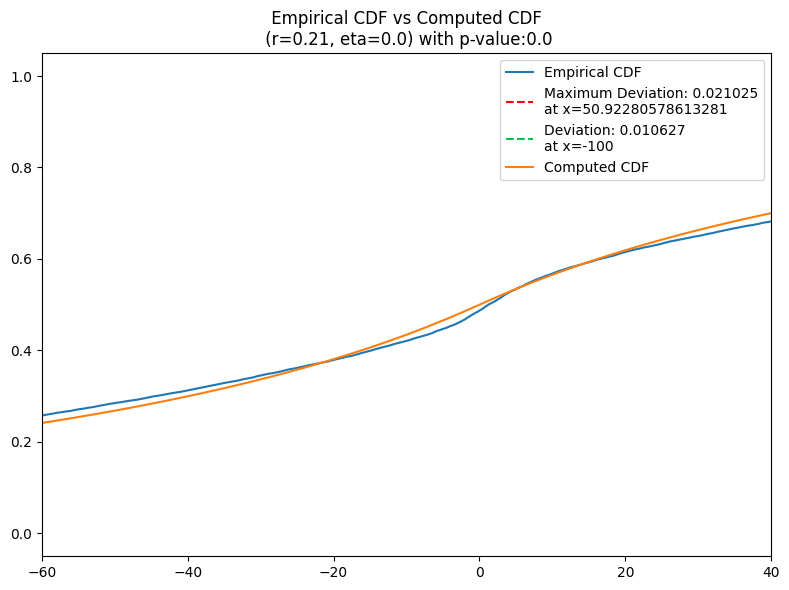

In [12]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

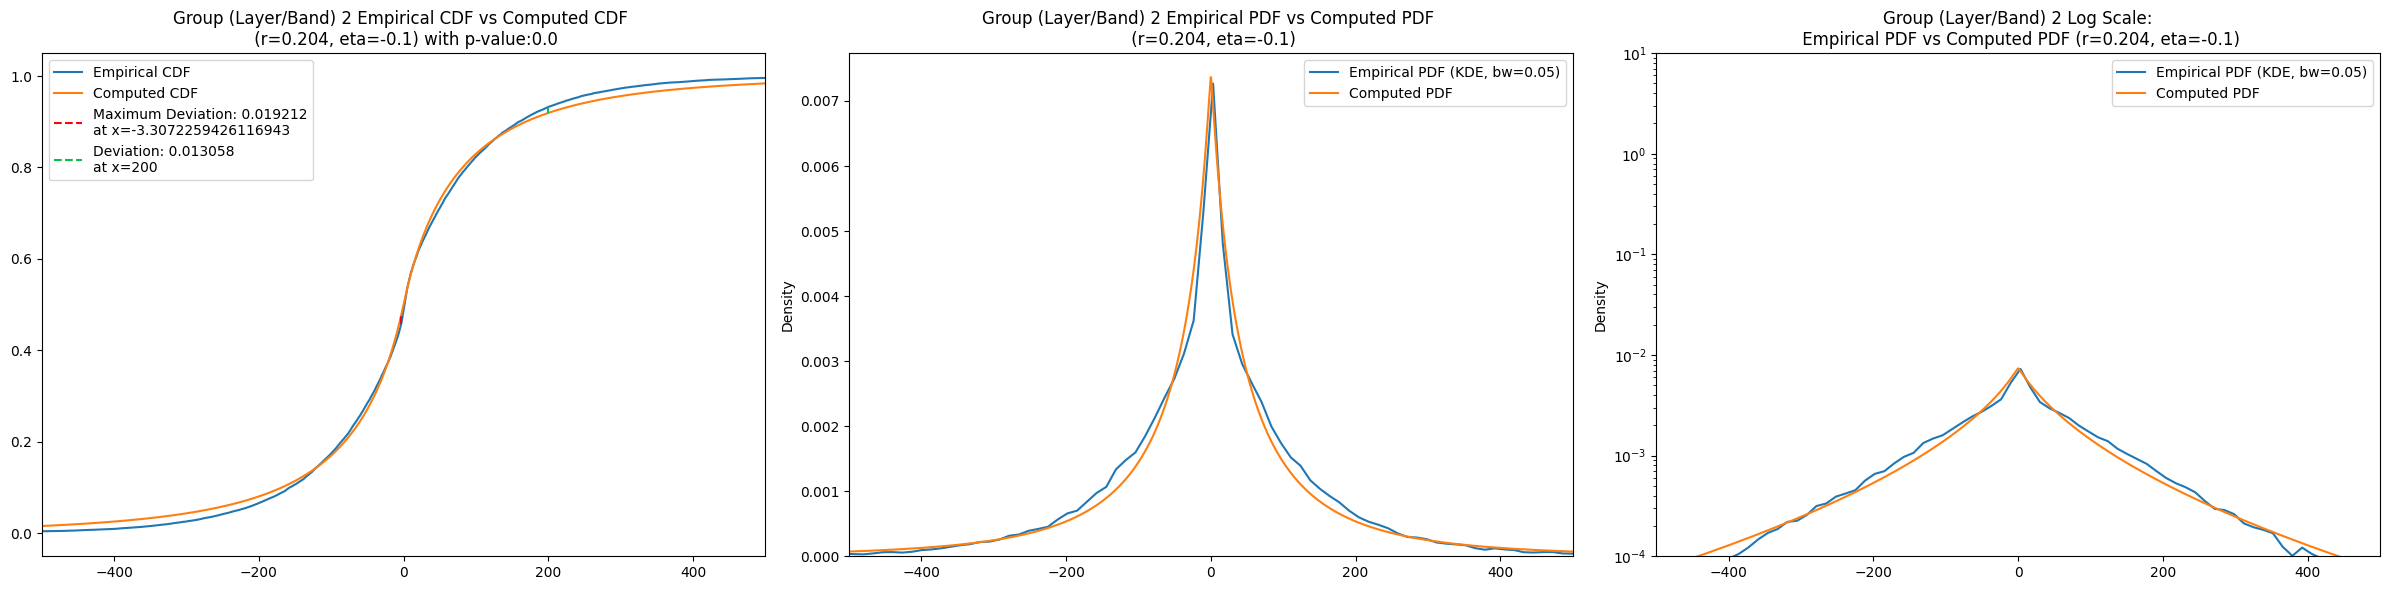

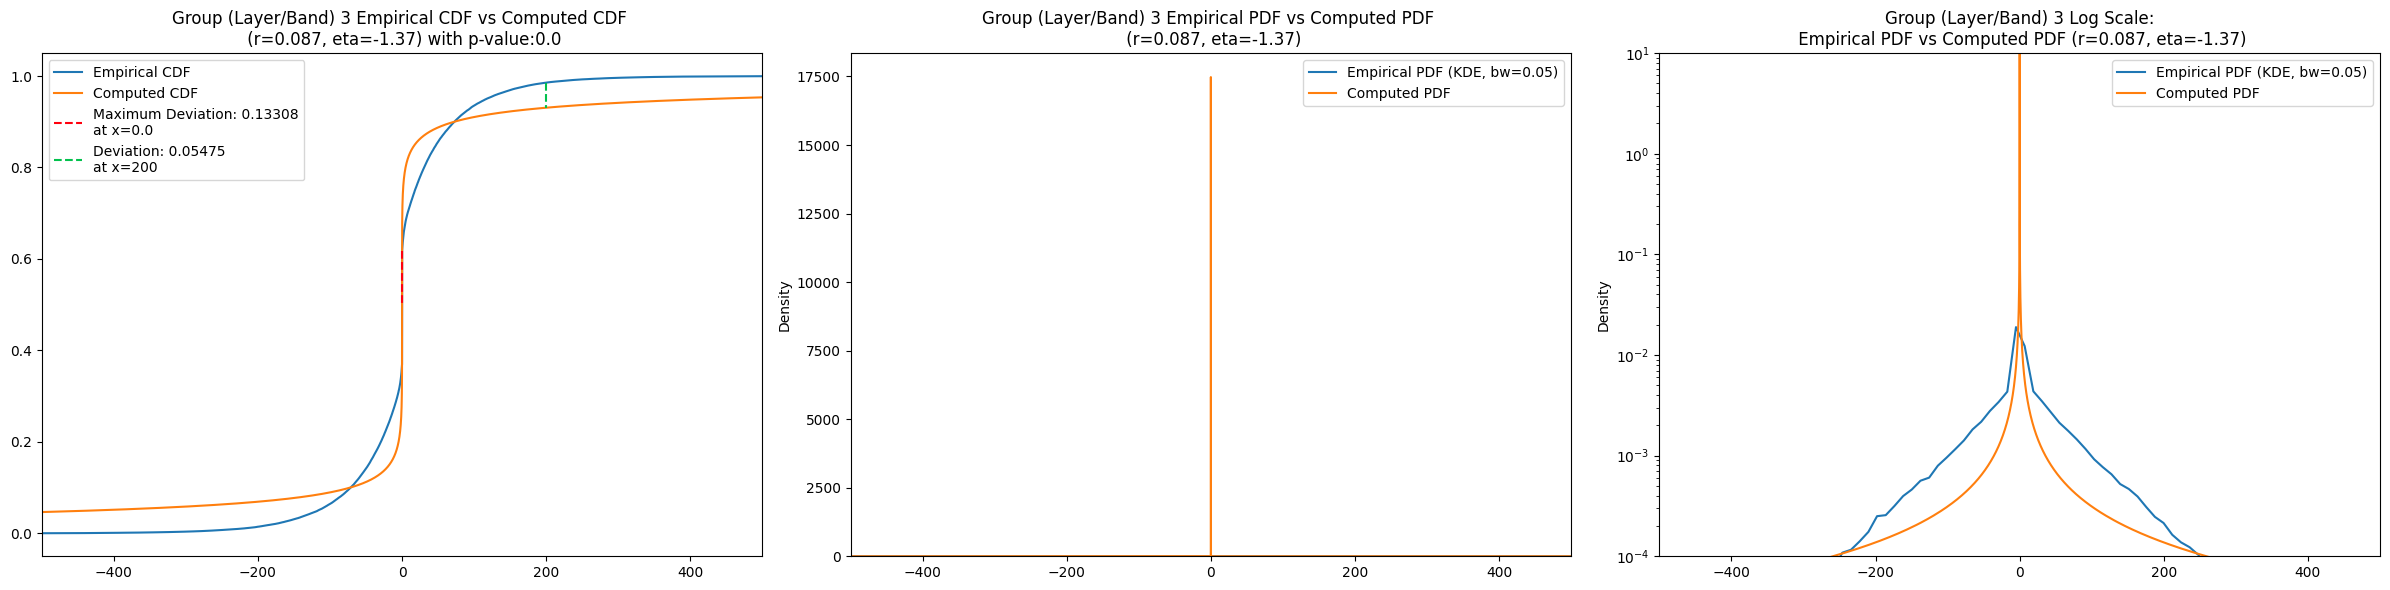

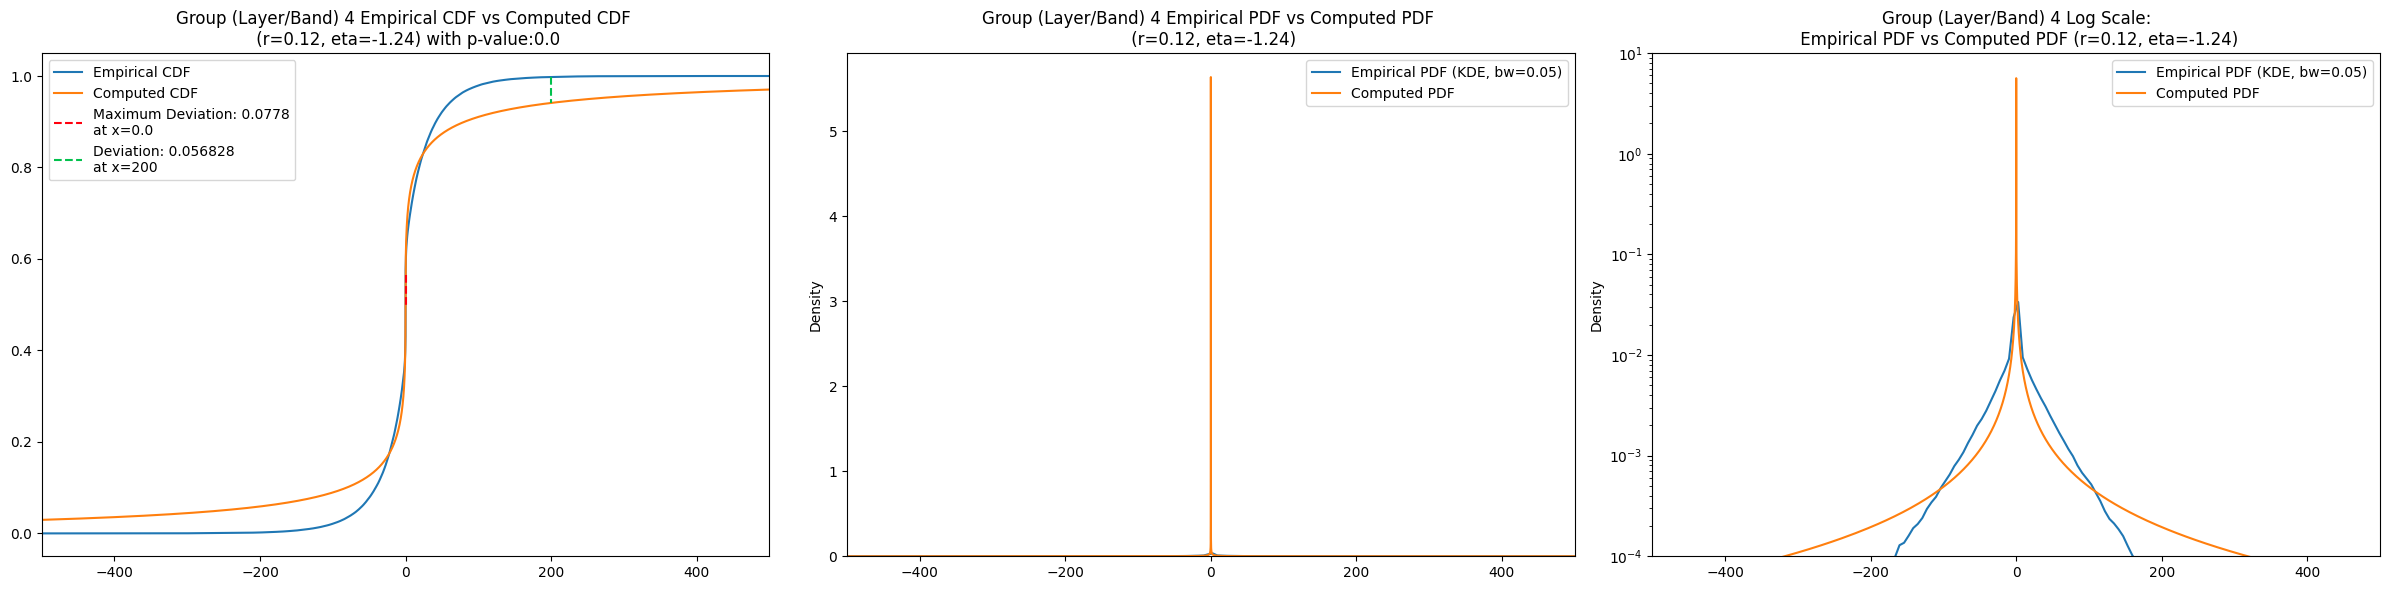

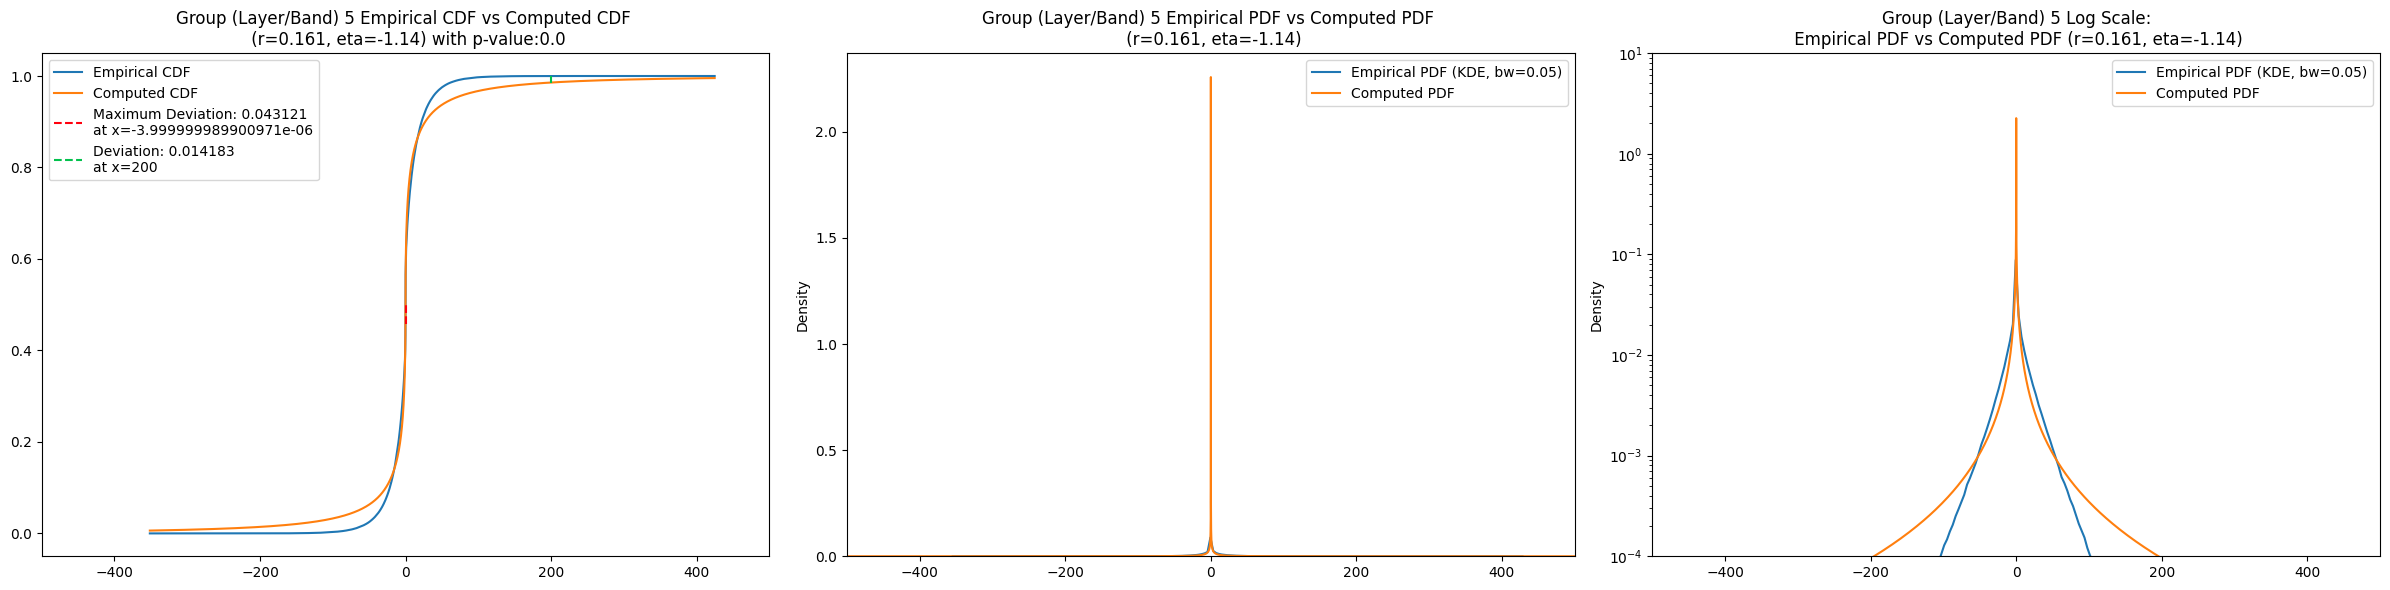

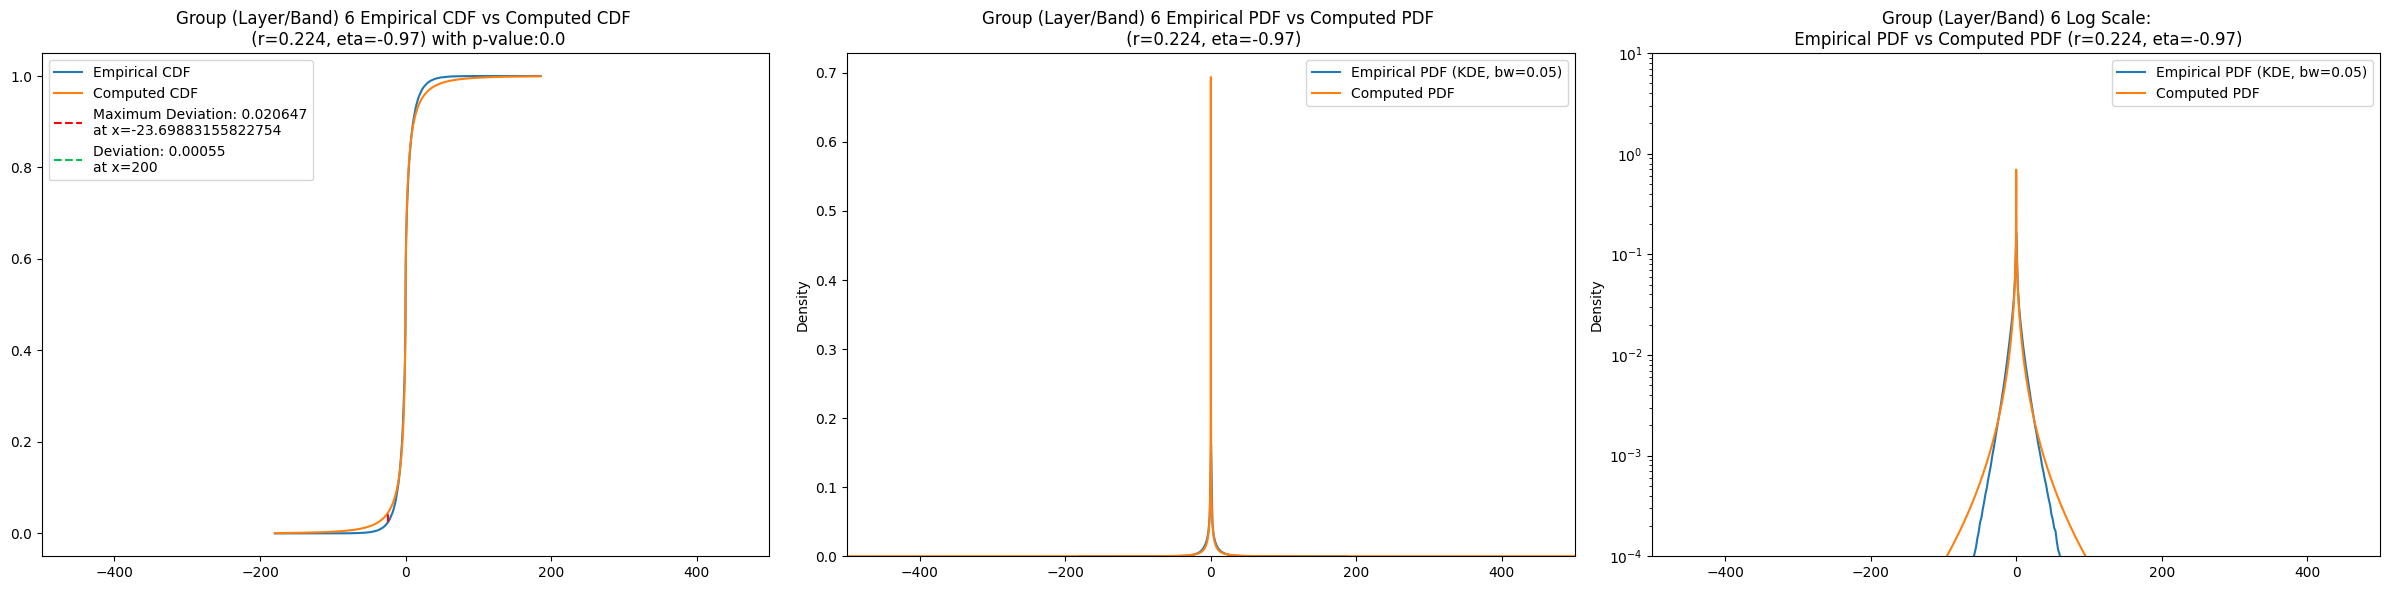

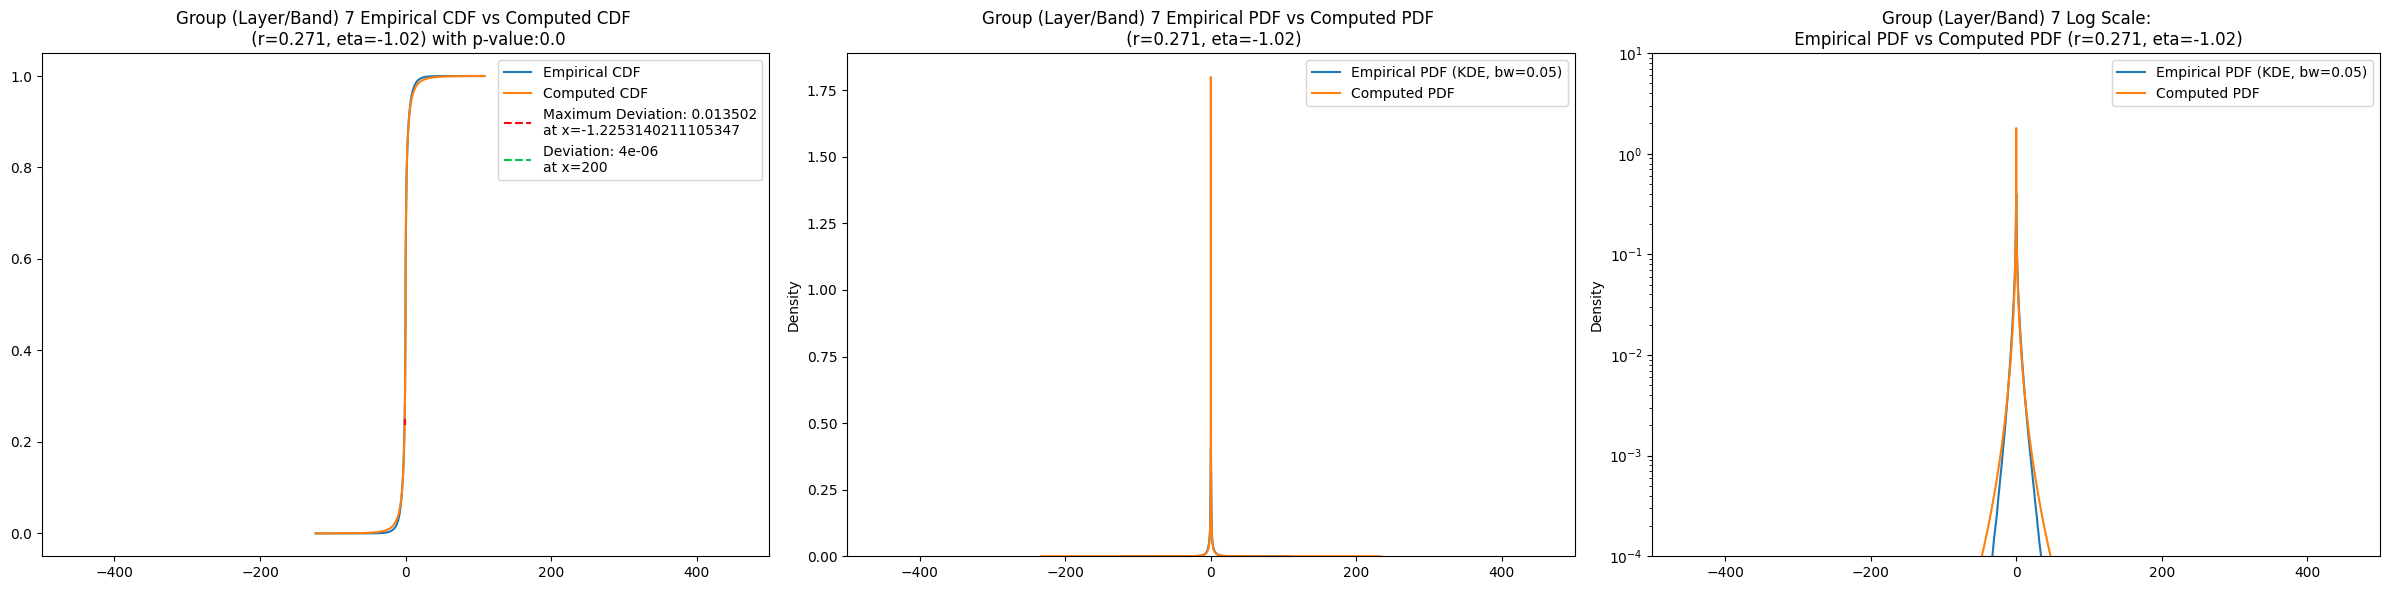

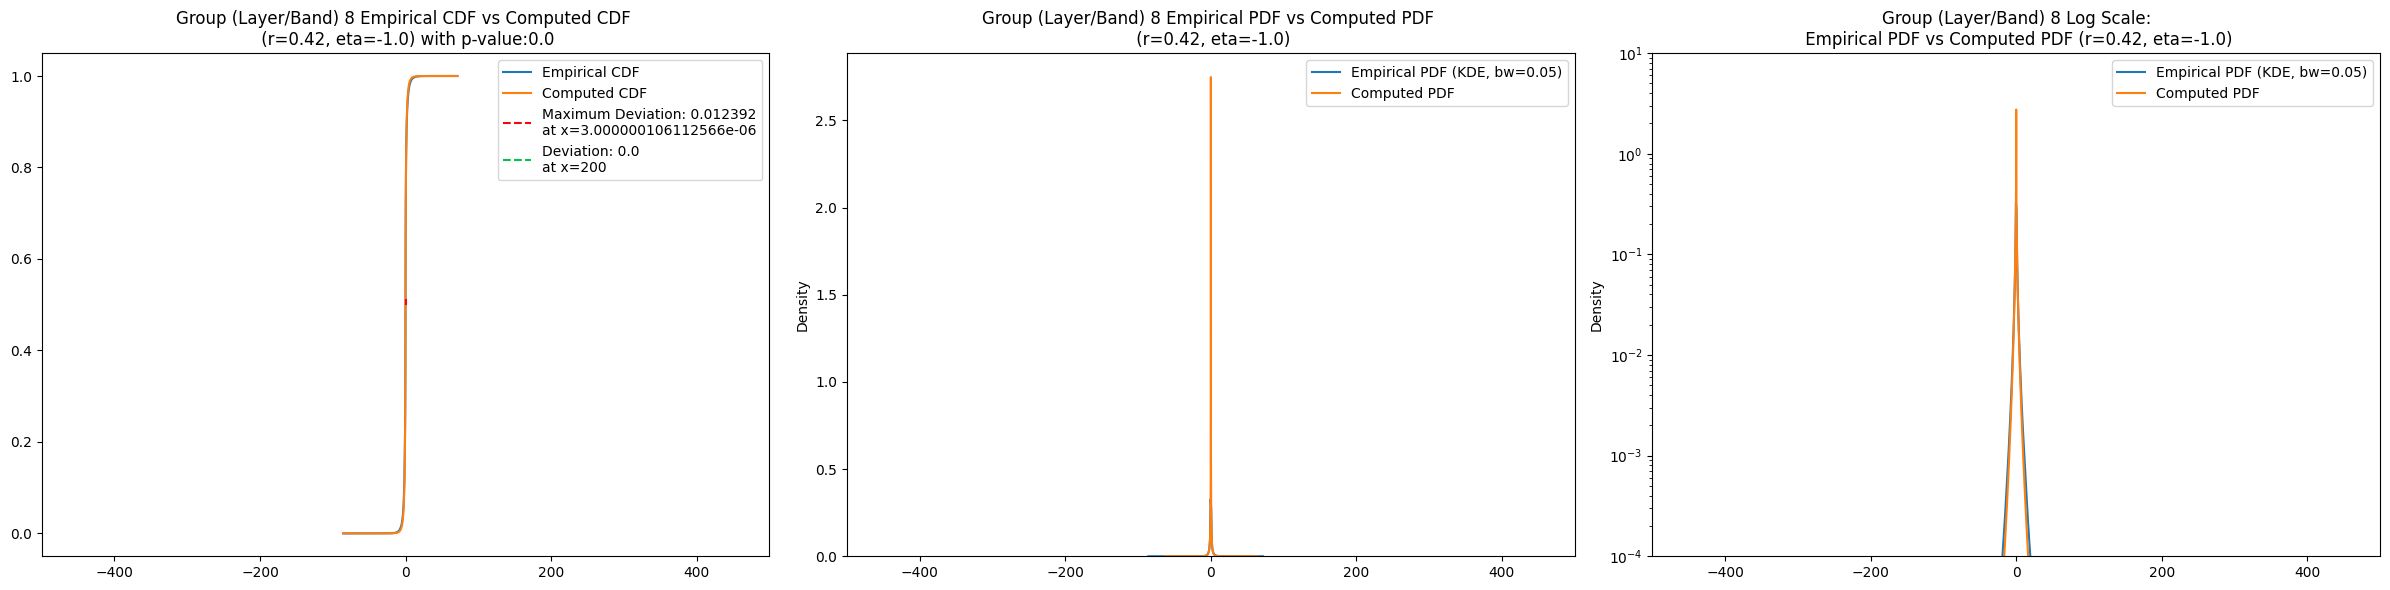

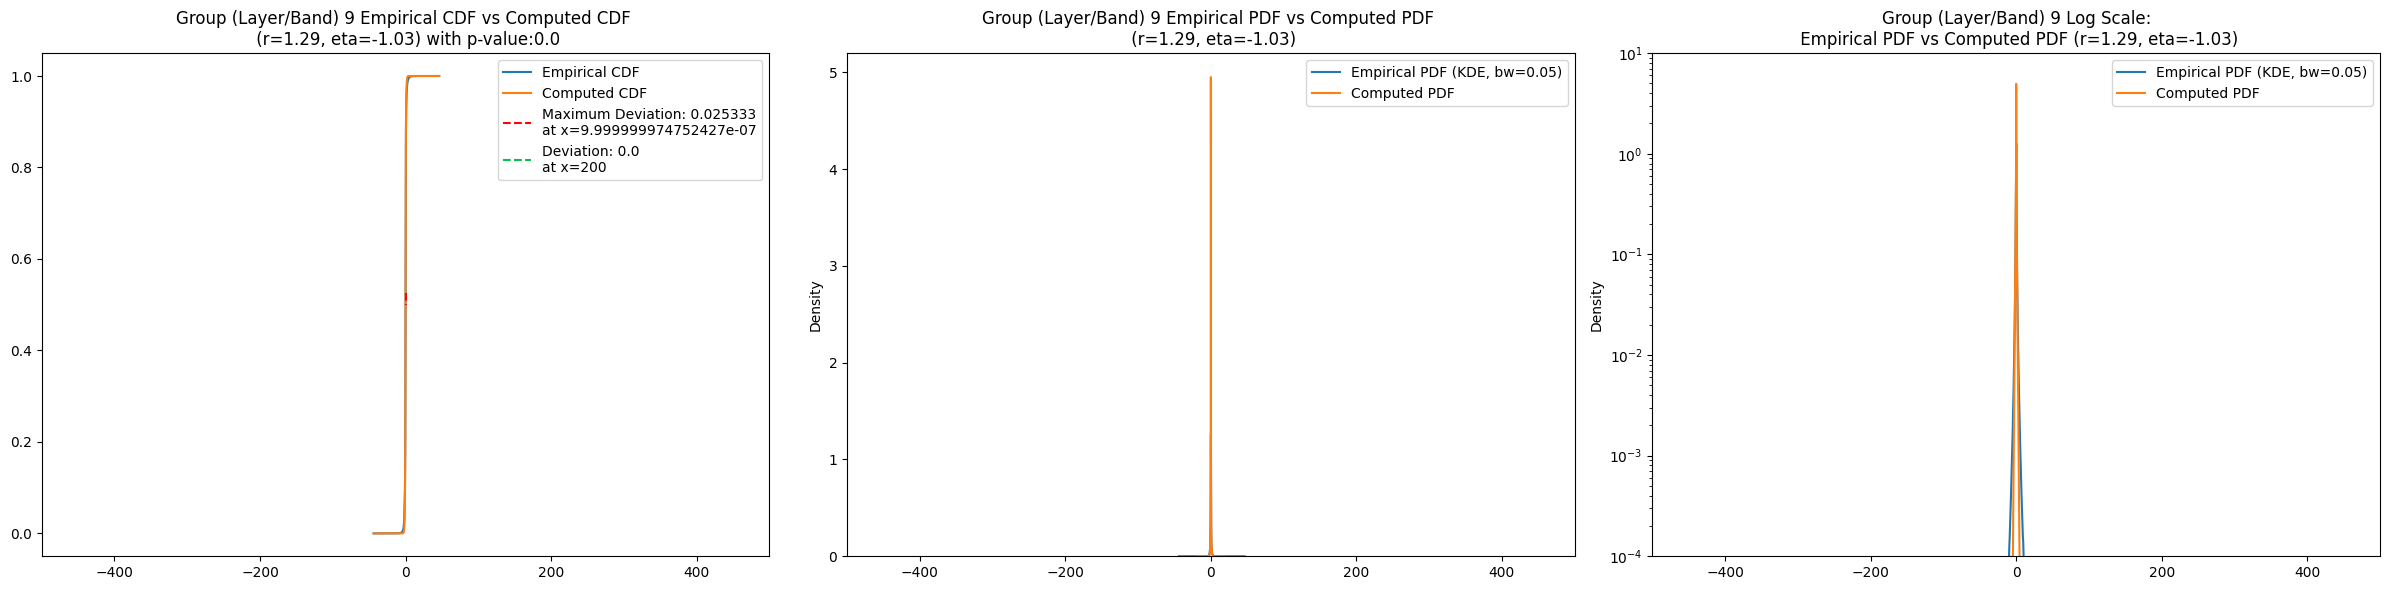

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,20586.120000,19743.030059,21437.694551,4.579008,3.532621,5.910701,27208.0,0.21,0.0,0.021025,...,102.032000,0.043843,6.952370e-46,84.795100,0.025508,8.221370e-16,71.377200,0.030389,2.902260e-22,3.735100e-09
3,5586.042500,5417.664475,5765.354583,12.162527,9.413560,15.798087,108832.0,0.09,-1.3,0.133080,...,22.542500,0.133839,0.000000e+00,15.517800,0.133090,0.000000e+00,12.501500,0.133090,0.000000e+00,0.000000e+00
4,1803.625200,1755.617276,1853.797237,9.509400,8.019747,11.794445,333298.0,0.13,-1.2,0.077800,...,16.978200,0.103783,0.000000e+00,13.106600,0.091381,0.000000e+00,10.581900,0.094232,0.000000e+00,0.000000e+00
5,518.531700,503.764754,533.565198,10.222363,8.006937,14.123384,1149538.0,0.17,-1.1,0.043123,...,9.975750,0.089730,0.000000e+00,7.723580,0.076333,0.000000e+00,6.212520,0.079245,0.000000e+00,0.000000e+00
6,123.448410,119.933077,127.200839,10.630472,8.700920,13.620480,4251250.0,0.22,-1.0,0.027734,...,5.256450,0.077096,0.000000e+00,4.226530,0.058957,0.000000e+00,3.410630,0.062675,0.000000e+00,0.000000e+00
7,26.474886,25.543394,27.486594,18.564667,12.586223,29.577342,17005000.0,0.28,-1.0,0.015915,...,2.104050,0.082592,0.000000e+00,1.739330,0.060916,0.000000e+00,1.379530,0.064300,0.000000e+00,0.000000e+00
8,5.566022,5.285992,5.909213,45.434103,18.767398,96.195189,68020000.0,0.42,-1.0,0.012391,...,0.881626,0.079140,0.000000e+00,0.763693,0.052915,0.000000e+00,0.599470,0.053934,0.000000e+00,0.000000e+00
9,1.021803,0.950948,1.125916,105.147970,24.340990,239.327557,272080000.0,1.30,-1.0,0.025334,...,0.445630,0.060203,0.000000e+00,0.392224,0.033041,0.000000e+00,0.312649,0.031429,0.000000e+00,0.000000e+00


In [16]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [17]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [18]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,20586.120000,19743.030059,21437.694551,4.579008,3.532621,5.910701,27208.0,0.21,0.0,0.021025,...,102.032000,0.043843,6.952370e-46,84.795100,0.025508,8.221370e-16,71.377200,0.030389,2.902260e-22,3.735100e-09
3,5586.042500,5417.664475,5765.354583,12.162527,9.413560,15.798087,108832.0,0.09,-1.3,0.133080,...,22.542500,0.133839,0.000000e+00,15.517800,0.133090,0.000000e+00,12.501500,0.133090,0.000000e+00,0.000000e+00
4,1803.625200,1755.617276,1853.797237,9.509400,8.019747,11.794445,333298.0,0.13,-1.2,0.077800,...,16.978200,0.103783,0.000000e+00,13.106600,0.091381,0.000000e+00,10.581900,0.094232,0.000000e+00,0.000000e+00
5,518.531700,503.764754,533.565198,10.222363,8.006937,14.123384,1149538.0,0.17,-1.1,0.043123,...,9.975750,0.089730,0.000000e+00,7.723580,0.076333,0.000000e+00,6.212520,0.079245,0.000000e+00,0.000000e+00
6,123.448410,119.933077,127.200839,10.630472,8.700920,13.620480,4251250.0,0.22,-1.0,0.027734,...,5.256450,0.077096,0.000000e+00,4.226530,0.058957,0.000000e+00,3.410630,0.062675,0.000000e+00,0.000000e+00
7,26.474886,25.543394,27.486594,18.564667,12.586223,29.577342,17005000.0,0.28,-1.0,0.015915,...,2.104050,0.082592,0.000000e+00,1.739330,0.060916,0.000000e+00,1.379530,0.064300,0.000000e+00,0.000000e+00
8,5.566022,5.285992,5.909213,45.434103,18.767398,96.195189,68020000.0,0.42,-1.0,0.012391,...,0.881626,0.079140,0.000000e+00,0.763693,0.052915,0.000000e+00,0.599470,0.053934,0.000000e+00,0.000000e+00
9,1.021803,0.950948,1.125916,105.147970,24.340990,239.327557,272080000.0,1.30,-1.0,0.025334,...,0.445630,0.060203,0.000000e+00,0.392224,0.033041,0.000000e+00,0.312649,0.031429,0.000000e+00,0.000000e+00
